In [1]:
import random
import seaborn
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from math import sqrt
from Def_funciones import *
from prophet import Prophet
from darts import TimeSeries
from matplotlib import pyplot
from multiprocess import cpu_count
from warnings import catch_warnings
from joblib import Parallel, delayed
from warnings import filterwarnings
from pandas import DataFrame, concat
from numpy import array, mean, std, median
from darts.models import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing


The `LightGBM` module could not be imported. To enable LightGBM support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
The `CatBoost` module could not be imported. To enable CatBoost support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md


### Análisis Exploratorio:

*SHAMPOO*

Information dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Month   36 non-null     object 
 1   Sales   36 non-null     float64
dtypes: float64(1), object(1)
memory usage: 708.0+ bytes


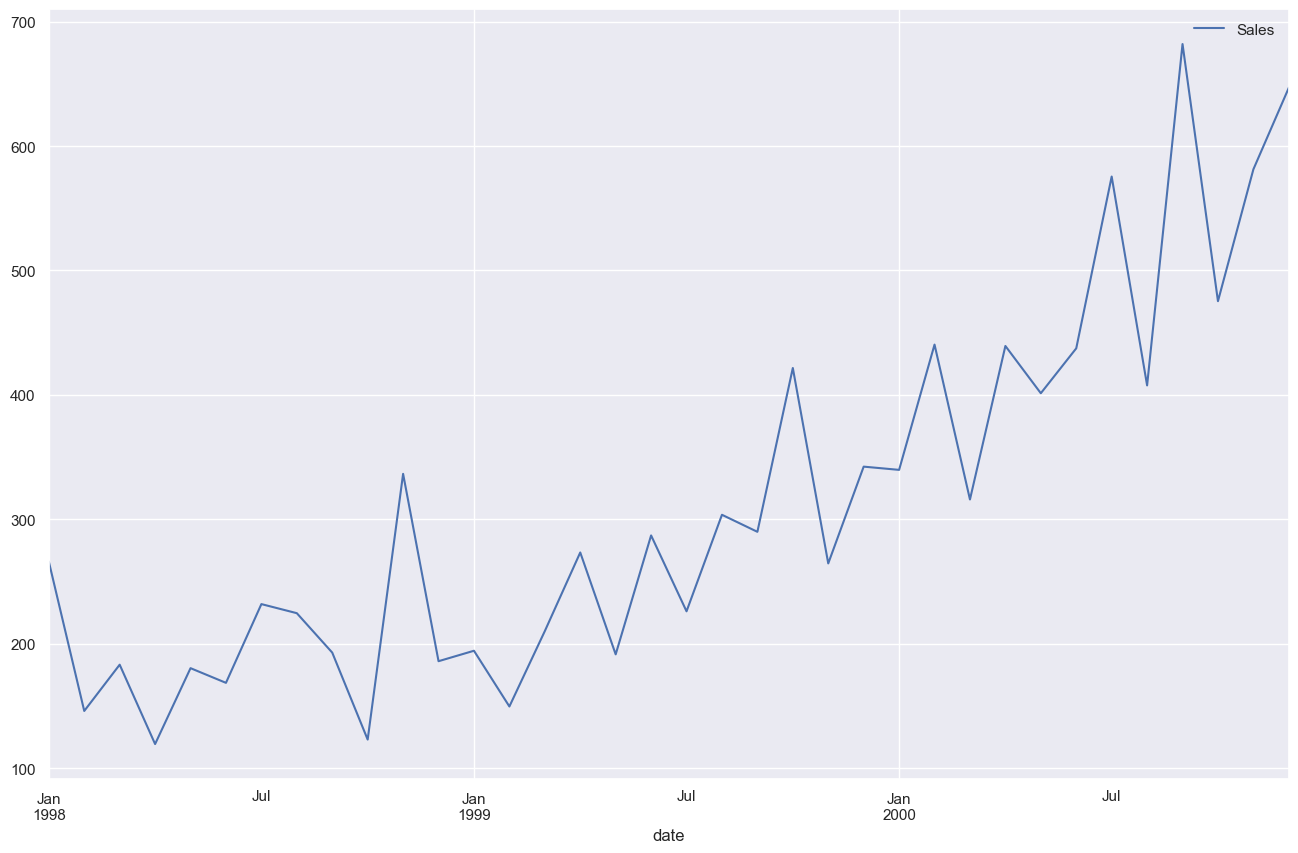

In [2]:
series = pd.read_csv('./data/shampoo.csv', header=0)
print("Information dataset")
series.info()

series["Year"] = [1998] * 12 + [1999] * 12 + [2000] * 12
series["Month"] = list(range(1,13)) * 3
series["Date"] = series["Month"].apply(str) + "-" + series["Year"].apply(str)
series['date']  = pd.to_datetime(series["Date"])
series = series[["date","Sales"]]
series.set_index(['date'],inplace = True)

seaborn.set()
series.plot(figsize = (16,10))
plt.savefig('shampoo.png')

### Promedios

In [3]:
def config_simple(long_max, offsets = [1]):
    configs = []
    for i in range(1, long_max + 1):
        for t in ['mediana',"promedio"]:
            cfg = [i, t]
            configs.append(cfg)
    return configs

# prediccion de un paso por promedio
def prediccion_promedio(historia, config):
    n, tipo_promedio = config
    if tipo_promedio == 'promedio':
        return mean(historia[-n:])
    return median(historia[-n:])

*SHAMPOO*

Tamaño Entrenamiento 29
Tamaño Prueba 7
58
terminado
[3, 'promedio'] 111.5106230258761 AA
[2, 'mediana'] 113.1503361525213 AA
[2, 'promedio'] 113.1503361525213 AA


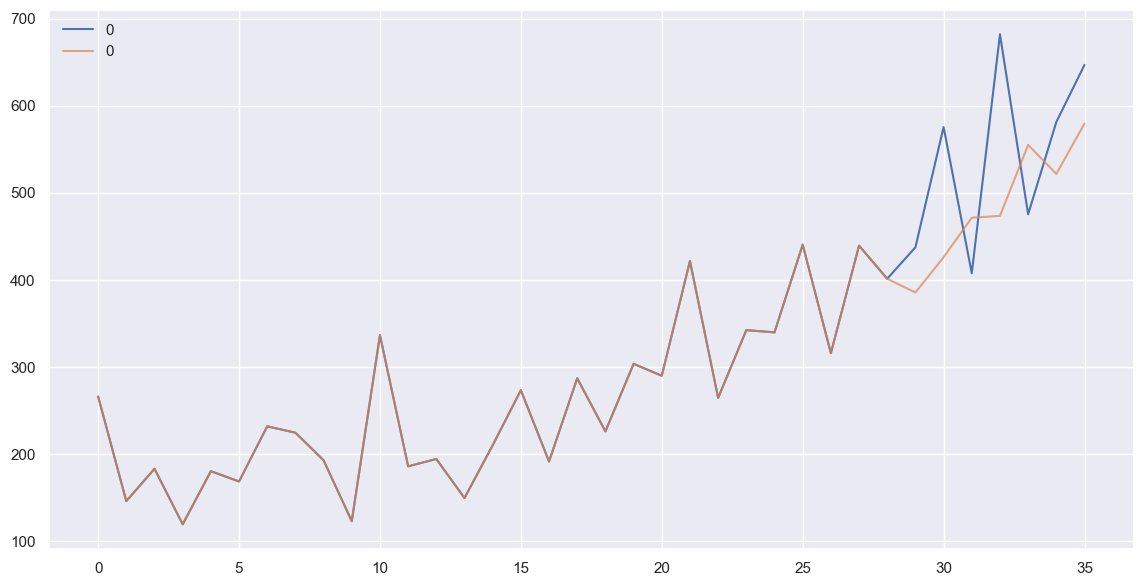

In [4]:
series = pd.read_csv('./data/shampoo.csv', header = 0, index_col = 0)
nombre="shampoo"
metodo = "promedio"
muestra = False
# encontrar_mejor_solucion(series, nombre, metodo = "sarima")
# def encontrar_mejor_solucion(series, nombre, metodo = "sarima", muestra = False):
datos = series.values
resultados = []
n_prueba = int(len(datos) * 0.2) # porcenta usado para prueba
long_max = len(datos) - n_prueba
print(f"Tamaño Entrenamiento {long_max}")
print(f"Tamaño Prueba {n_prueba}")

# configuraciones de los modelos

lista_cfg = config_simple(long_max)
# muestrear algunos
if muestra:
    lista_cfg_azar = random.sample(lista_cfg, k = 25)
    while len(resultados) < 5:
        lista_cfg_azar = random.sample(lista_cfg, k = 25)
        resultados += busqueda_malla(datos, lista_cfg_azar, n_prueba, metodo)
else:
    # búsqueda en malla
    resultados = busqueda_malla(datos, lista_cfg, n_prueba, metodo)
    

# ordenan las configuraciones por error, ascendente
resultados.sort(key = lambda tup: tup[1])


print('terminado')
# listar las mejores 3 configuraciones
for cfg, error, predicciones in resultados[:3]:
    print(cfg, error ,"AA")
    rsme_pro_shampo = error
# desplegar
entreno, prueba = division_entreno_prueba(datos, n_prueba)
prediccion = pd.DataFrame(list(entreno.flatten()) + resultados[0][2])
ax = pd.DataFrame(datos).plot(label = "Original") # Datos originales
prediccion.plot(ax = ax, alpha = .7, figsize = (14,7))

plt.savefig(f"{nombre}_{metodo}.png", transparent = True)
plt.show()

### SARIMA

In [5]:
def prediccion_sarima(historia, config):
    orden, orden_estacional, tendencia = config
    # definir el modelo
    modelo = SARIMAX(historia, order = orden, seasonal_order = orden_estacional, trend = tendencia,
      enforce_stationarity = False, enforce_invertibility = False)
    # ajustar el model con los datos
    modelo_ajustado = modelo.fit(disp = False)
    # hacer la predicción de un paso
    yhat = modelo_ajustado.predict(len(historia), len(historia))
    return yhat[0]

def config_sarima(estacional = [0]):
    modelos = []
    # definir las listas de configuración
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct'] 
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = estacional
    # crear instancias de configuración
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    modelos.append(cfg)
    return modelos

*Shampoo*

Tamaño Entrenamiento 29
Tamaño Prueba 7
72
terminado
[(0, 1, 2), (0, 0, 0, 0), 'c'] 69.40192219899937
[(1, 0, 2), (0, 0, 0, 0), 't'] 70.12720363800007
[(1, 1, 1), (0, 0, 0, 0), 'ct'] 72.00875467562055


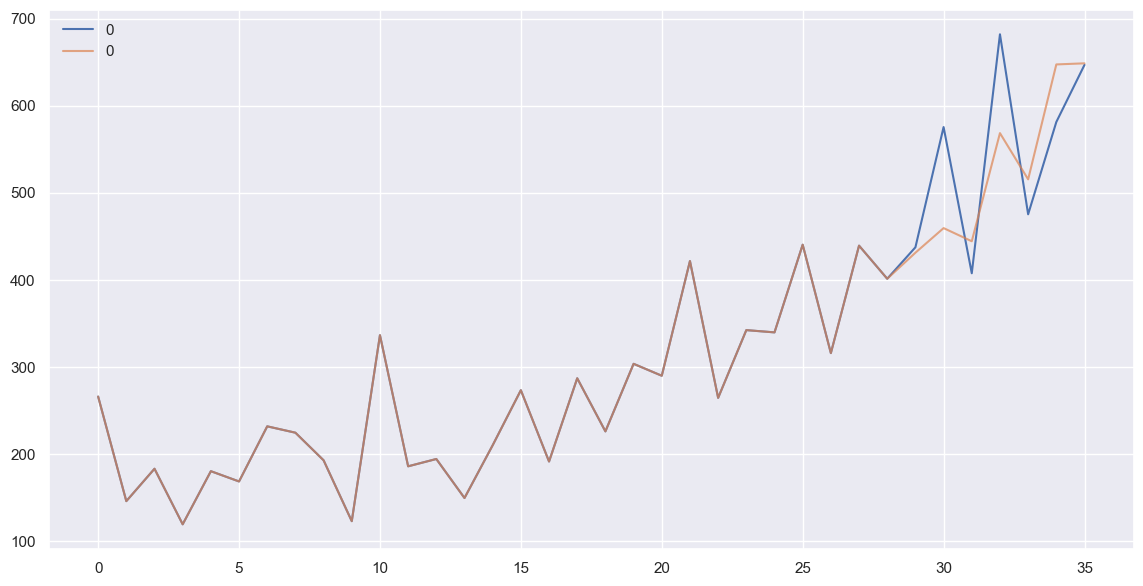

In [7]:
series = pd.read_csv('./data/shampoo.csv', header = 0, index_col = 0)
nombre="shampoo"
metodo = "sarima"
muestra = False
# encontrar_mejor_solucion(series, nombre, metodo = "sarima")
# def encontrar_mejor_solucion(series, nombre, metodo = "sarima", muestra = False):
datos = series.values
resultados = []
n_prueba = int(len(datos) * 0.2) # porcenta usado para prueba
long_max = len(datos) - n_prueba
print(f"Tamaño Entrenamiento {long_max}")
print(f"Tamaño Prueba {n_prueba}")

# configuraciones de los modelos

lista_cfg = config_sarima()
# muestrear algunos
if muestra:
    lista_cfg_azar = random.sample(lista_cfg, k = 25)
    while len(resultados) < 5:
        lista_cfg_azar = random.sample(lista_cfg, k = 25)
        resultados += busqueda_malla(datos, lista_cfg_azar, n_prueba, metodo)
else:
    # búsqueda en malla
    resultados = busqueda_malla(datos, lista_cfg, n_prueba, metodo)
    

# ordenan las configuraciones por error, ascendente
resultados.sort(key = lambda tup: tup[1])


print('terminado')
# listar las mejores 3 configuraciones
for cfg, error, predicciones in resultados[:3]:
    print(cfg, error)
    rsme_sar_shampo = error

# desplegar
entreno, prueba = division_entreno_prueba(datos, n_prueba)
prediccion = pd.DataFrame(list(entreno.flatten()) + resultados[0][2])
ax = pd.DataFrame(datos).plot(label = "Original") # Datos originales
prediccion.plot(ax = ax, alpha = .7, figsize = (14,7))

plt.savefig(f"{nombre}_{metodo}.png", transparent = True)
plt.show()



### Alisamiento Exponencial

*SHAMPOO*

In [8]:
datos = pd.read_csv('./data/shampoo.csv', delimiter=",")
datos.head()
serie = TimeSeries.from_dataframe(datos, "Month", "Sales")
entreno, validacion = serie[:-36], serie[-36:]
modelo = ExponentialSmoothing()
modelo.fit(entreno)
prediccion = modelo.predict(len(validacion), num_samples = 1000)
serie.plot()
prediccion.plot(label = "predicción", low_quantile = 0.05, high_quantile = 0.95)
plt.legend()

AttributeError: 'time_col' is of 'object' dtype but doesn't contain valid timestamps


AttributeError: 'time_col' is of 'object' dtype but doesn't contain valid timestamps

### Prophet

In [9]:
def evaluar_prediccion(series, frecuencia = "M"):
    datos = series
    n_entreno = int(len(datos) * 0.8) # porcentaje usado para entreno
    long_max = len(datos) - n_entreno
    print(f"Tamaño entreno {n_entreno} ")
    print(f"Tamaño prueba {long_max} ")
    lista_cfg = [1]
    entreno, prueba = division_entreno_prueba(datos, n_entreno)
    modelo = Prophet(mcmc_samples = 500, seasonality_mode = 'multiplicative').fit(series);
    futuro = modelo.make_future_dataframe(periods = len(prueba),freq = frecuencia)
    predicciones = modelo.predict(futuro)
    modelo.plot(predicciones)
    rmse = medir_rmse(predicciones.iloc[len(entreno):len(series)]["yhat"], prueba["y"])
   
    return rmse

def parse_date (x): 
    return datetime.datetime.strptime("0"+str(x), '%y-%m') 

*SHAMPOO*

Tamaño entreno 28 
Tamaño prueba 8 


23:36:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

23:37:00 - cmdstanpy - INFO - CmdStan done processing.
23:37:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if t

23:37:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

23:37:07 - cmdstanpy - INFO - CmdStan done processing.
23:37:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'C:/Users/runneradmin/AppData/Local/Temp/tmpj_ap_iv6/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True 

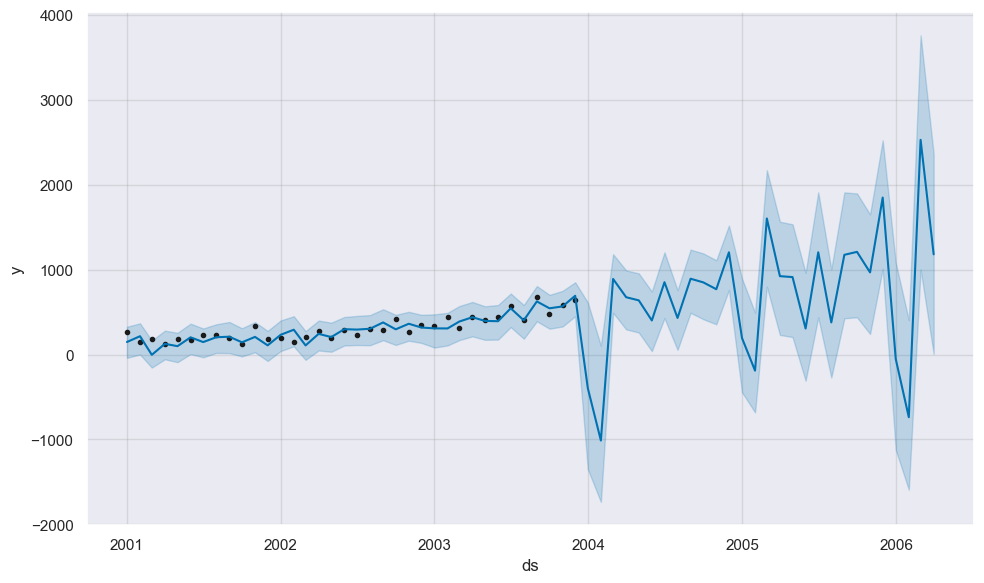

In [10]:
series = pd.read_csv('./data/shampoo.csv', header=0)
series['ds']  = series['Month'].apply(lambda x: parse_date(x))
series[['y']] = series[['Sales']].astype(float)
series = series[["ds","y"]]
rmse_SHAMPOO = evaluar_prediccion(series)

modelo = Prophet(mcmc_samples = 500, seasonality_mode = 'multiplicative').fit(series);

### Redes Neuronales

In [11]:
def division_entreno_prueba(datos, n_prueba):
    return datos[:-n_prueba], datos[-n_prueba:]

def series_a_supervisado(datos, n_entrada, n_salida = 1):
    df = DataFrame(datos)
    cols = []
	# secuencia de entrada (t-n, ... t-1)
    for i in range(n_entrada, 0, -1):
	    cols.append(df.shift(i))
    # secuencia predicha (t, t+1, ... t+n)
    for i in range (0, n_salida):
	    cols.append(df.shift(-i))
    # juntarlo todo
    agg = concat(cols, axis = 1)
	# botar columnas con valores NaN
    agg.dropna(inplace = True)
    return agg.values

def medir_rmse(actual, predicho):
    return sqrt(mean_squared_error(actual, predicho))

def ajustar_modelo(entreno, config):
	# desempacar la configuración
	n_entrada, n_nodos, n_epocas, n_tandas = config
    #[24, 500, 100, 100]
    # preparar los datos
	datos = series_a_supervisado(entreno, n_entrada)
	entreno_x, entreno_y = datos[:, :-1], datos[:, -1]
	# definir el modelo
	modelo = tf.keras.Sequential()
	modelo.add(tf.keras.layers.Dense(n_nodos, activation='relu', input_dim = n_entrada))
	modelo.add(tf.keras.layers.Dense(1))
	modelo.compile(loss='mse', optimizer='adam')
	# ajustar
	modelo.fit(entreno_x, entreno_y, epochs = n_epocas, batch_size = n_tandas, verbose = 0)
	return modelo

def prediccion_modelo(modelo, historia, config):
    	# desempacar la configuración
	n_entrada, _, _, _ = config
	# preparar los datos
	x_entrada = array(historia[-n_entrada:]).reshape(1, n_entrada)
	# predecir
	yhat = modelo.predict(x_entrada, verbose = 0)
	return yhat[0]

def validacion_al_frente(datos, n_prueba, cfg):
    predicciones = []
    # dividir el conjunto de datos
    entreno, prueba = division_entreno_prueba(datos, n_prueba)
    # ajustar el modelo
    modelo = ajustar_modelo(entreno, cfg)
    # grabar la historia con el conjunto de datos de entrenamiento
    historia = [x for x in entreno]
    # pasar por cada incremento de tiempo en el conjunto de prueba
    for i in range(len(prueba)):
        # ajustar el modelo a los datos y predecir los datos históricos
        yhat = prediccion_modelo(modelo, historia, cfg)
        # agregar el dato predicho en la lista de preducciones
        predicciones.append(yhat)
        # agregar la observación a la historia para la siguiente iteración
        historia.append(prueba[i])
    # estimar el error de las predicciones
    error = medir_rmse(prueba, predicciones)
    print(f' > {error:.3f}')
    return [error, predicciones]

def evaluacion_iter(datos, config, n_prueba, n_repeticiones = 5):
    	# ajustar y evaluar el modelo n veces
    resultados = []
    predicciones = []
    for _ in range(n_repeticiones):
        resultados_temp, predicciones_temp = validacion_al_frente(datos, n_prueba, config)
        resultados.append(resultados_temp)
        predicciones.append(predicciones_temp)
    return [resultados, predicciones]
      
def buscar_mejor_solucion(series, nombre, metodo = "red neuronal"):
    datos = series.values
    n_prueba = int(len(datos)*0.2) # porcentaje utilizado para prueba
    config = [24, 500, 100, 100]
    resultados, predicciones = evaluacion_iter(datos, config, n_prueba)
    plt.savefig("resultados_{nombre}_{metodo}.png")
    plt.show()
    entreno, prueba = division_entreno_prueba(datos,n_prueba)
    prediccion = pd.DataFrame(list(entreno.flatten()) + np.array(predicciones[0]).flatten().tolist())
    ax = pd.DataFrame(datos).plot(label="Original") # datos originales
    prediccion.plot(ax=ax, alpha=.7, figsize=(14,7))
    plt.savefig("pred_{nombre}_{metodo}.png")
    plt.show()
    return resultados

*SHAMPOO*

 > 110.047
 > 120.417
 > 123.973
 > 113.849
 > 114.707


<Figure size 640x480 with 0 Axes>

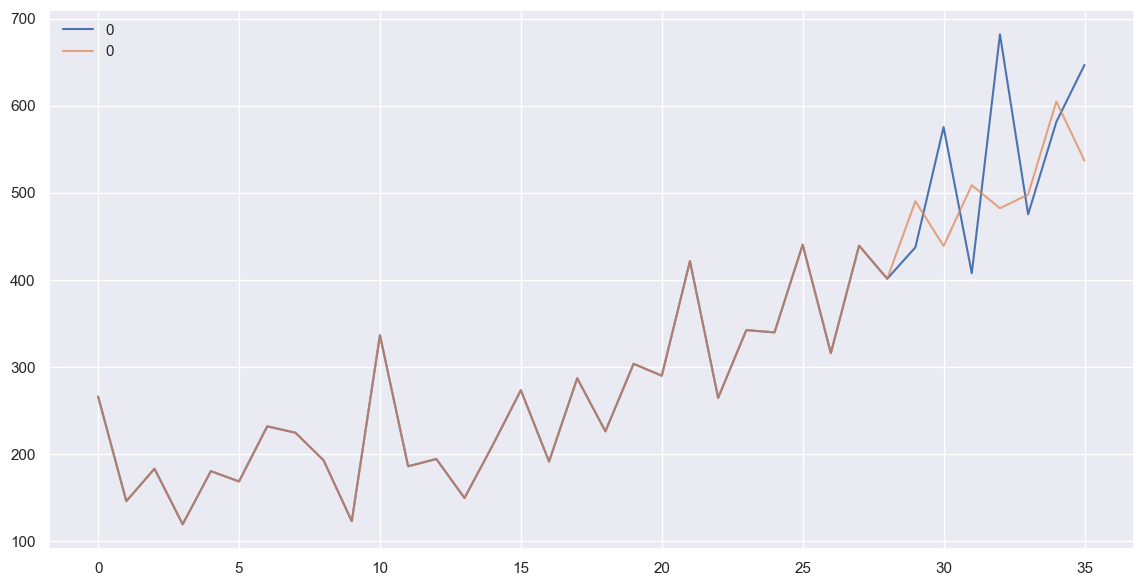

In [12]:
series = pd.read_csv('./data/shampoo.csv', header=0, index_col=0)
r_shampoo = buscar_mejor_solucion(series,"shampoo")

### Comparación y Evaluación

In [15]:
def resumir_resultados(nombre, resultados):
    	# imprimir un resúmen
	media_result, std_result = mean(resultados), std(resultados)
	print(f'{nombre}: {media_result:.3f} RMSE (+/- {std_result:.3f})')
	# gráficas de caja y bigotes
	pyplot.boxplot(resultados)
	pyplot.show()
	return std_result

*SHAMPOO*

Prophet
RMSE: 68.76682994495313
Redes Neuronales
mlp: 116.598 RMSE (+/- 4.960)


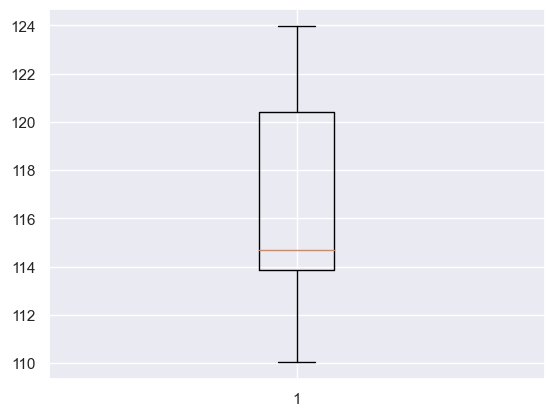

RMSE: 4.960172137979267
Promedio
RMSE: 113.1503361525213
SARIMA
RMSE: 72.00875467562055


In [16]:
print("Prophet")
print(f"RMSE: {rmse_SHAMPOO}")

print("Redes Neuronales")
rsme_red_SHAMPOO = resumir_resultados('mlp', r_shampoo)
print(f"RMSE: {rsme_red_SHAMPOO}")

print("Promedio")
print(f"RMSE: {rsme_pro_shampo}")
    
print("SARIMA")
print(f"RMSE: {rsme_sar_shampo}")